# Filtering and Restoring of Mixed and Noise Polluted Audio Samples Using Different Approaches

# 3. Wavelet Transform

## Load Edited Audio Samples

In [1]:
import os
import soundfile as sf
import numpy as np

inp_mixed_folder = 'mixed_signals'
inp_folder = 'audio_samples'
wavelet_folder = 'wavelet_samples'

Load Original Audio Files

In [2]:
file_names = ['speech.wav', 'street.wav', 'music.wav', 'white_noise.wav']

audio_speech, sr_speech = sf.read(os.path.join(inp_folder, file_names[0]))
audio_street, sr_street = sf.read(os.path.join(inp_folder, file_names[1]))
audio_music, sr_music = sf.read(os.path.join(inp_folder, file_names[2]))
audio_wnoise, sr_wnoise = sf.read(os.path.join(inp_folder, file_names[3]))
print("Array Type is: {}".format(audio_music.dtype))

audio_files = [audio_speech, audio_street, audio_music, audio_wnoise]
sample_rates = [sr_speech, sr_street, sr_music, sr_wnoise]

for name, sr, audio in zip(file_names, sample_rates, audio_files):
    print("File: {}, Sample Rate: {}, Samples: {}, Time: {}sec".format(name, sr, len(audio), len(audio)/sr))

Array Type is: float64
File: speech.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: street.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: music.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: white_noise.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec


Load Mixed Signals

Generate four observations $d$. 

1. Music + White Noise $d_{m+wn}$
1. Street Noise + Music $d_{sn+m}$
1. Street Noise + Music + Speech $d_{sn+m+s}$
1. Speech + White Noise $d_{s+wn}$

In [3]:
file_names_obsv = ['music_wn.wav', 'street_music.wav', 'street_music_speech.wav', 'speech_wn.wav']

audio_m_wn, sr_m_wn = sf.read(os.path.join(inp_folder, file_names[0]))
audio_s_m, sr_s_m = sf.read(os.path.join(inp_folder, file_names[1]))
audio_s_m_sp, sr_s_m_sp = sf.read(os.path.join(inp_folder, file_names[2]))
audio_sp_wn, sr_sp_wn = sf.read(os.path.join(inp_folder, file_names[3]))
print("Array Type is: {}".format(audio_music.dtype))

observations = [audio_m_wn, audio_s_m, audio_s_m_sp, audio_sp_wn]
sample_rates_obsv = [sr_m_wn, sr_s_m, sr_s_m_sp, sr_sp_wn]
max_length = len(observations[0])

for name, sr, audio in zip(file_names_obsv, sample_rates_obsv, observations):
    print("File: {}, Sample Rate: {}, Samples: {}, Time: {}sec".format(name, sr, len(audio), len(audio)/sr))

Array Type is: float64
File: music_wn.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: street_music.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: street_music_speech.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec
File: speech_wn.wav, Sample Rate: 44100, Samples: 352800, Time: 8.0sec


# Wavelet Transform

Source:
* [Audio Classification using Wavelet Transform and Deep Learning, Aditya Dutt](https://medium.com/mlearning-ai/audio-classification-using-wavelet-transform-and-deep-learning-f9f0978fa246)
* [Choose a Wavelet, MathWorks](https://de.mathworks.com/help/wavelet/gs/choose-a-wavelet.html)
* https://www.kaggle.com/theoviel/denoising-with-direct-wavelet-transform

In [4]:
import pywt
import matplotlib.pyplot as plt

np.random.seed(10)

In [5]:
# print the wavelet families available
print(pywt.families())
# print a list of available wavelets from one family
print(pywt.wavelist(kind='discrete'))

['haar', 'db', 'sym', 'coif', 'bior', 'rbio', 'dmey', 'gaus', 'mexh', 'morl', 'cgau', 'shan', 'fbsp', 'cmor']
['bior1.1', 'bior1.3', 'bior1.5', 'bior2.2', 'bior2.4', 'bior2.6', 'bior2.8', 'bior3.1', 'bior3.3', 'bior3.5', 'bior3.7', 'bior3.9', 'bior4.4', 'bior5.5', 'bior6.8', 'coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 'rbio1.1', 'rbio1.3', 'rbio1.5', 'rbio2.2', 'rbio2.4', 'rbio2.6', 'rbio2.8', 'rbio3.1', 'rbio3.3', 'rbio3.5', 'rbio3.7', 'rbio3.9', 'rbio4.4', 'rbio5.5', 'rbio6.8', 'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym1

In [6]:
wavelet = 'db3'
mode = 'sym'

In [7]:
def madev(d, axis=None):
    """ Mean absolute deviation of a signal """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [8]:
def wavelet_denoising(signal, wavelet='db4', mode='per', level=1):
    coeff = pywt.wavedec(signal, wavelet, mode=mode)
    sigma = (1/0.6745) * madev(coeff[-level])
    uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    return pywt.waverec(coeff, wavelet, mode=mode)

In [9]:
def plot_wavelet(signal, wavelet='db4', mode='per'):
    coeffs = pywt.wavedec(signal, wavelet, mode=mode)
    fig, axs = plt.subplots(len(coeffs)+1, 1, figsize=[18, 30], sharex=True, constrained_layout = True)
    fig.supylabel('Amplitude', fontsize=20)

    axs[0].plot(signal, lw=5)
    axs[0].set_title('Mixed Data', fontsize=25)

    for ii, coeff in enumerate(coeffs):
        axs[ii+1].plot(coeff, lw=5)
        axs[ii+1].set_title('c'+ str(ii), fontsize=25)

    axs[len(coeffs)].set_xlabel('Samples', fontsize=20)

    for ax in axs:
        ax.set_xlim(0)
        ax.tick_params(labelsize=15)
        ax.grid()

In [10]:
compare_wavelets = False
if compare_wavelets:
    for wav in pywt.wavelist():
        try:
            filtered = wavelet_denoising(observations[0], wavelet=wav, mode=mode, level=1)
        except:
            pass
        plt.figure(figsize=(10, 6))
        plt.plot(filtered, '--', label='Filtered')
        plt.plot(observations[0], ':', label='Raw')
        plt.legend()
        plt.title(f"DWT Denoising with {wav} Wavelet", size=15)  

# Speech + White Noise $d_{s+wn}$

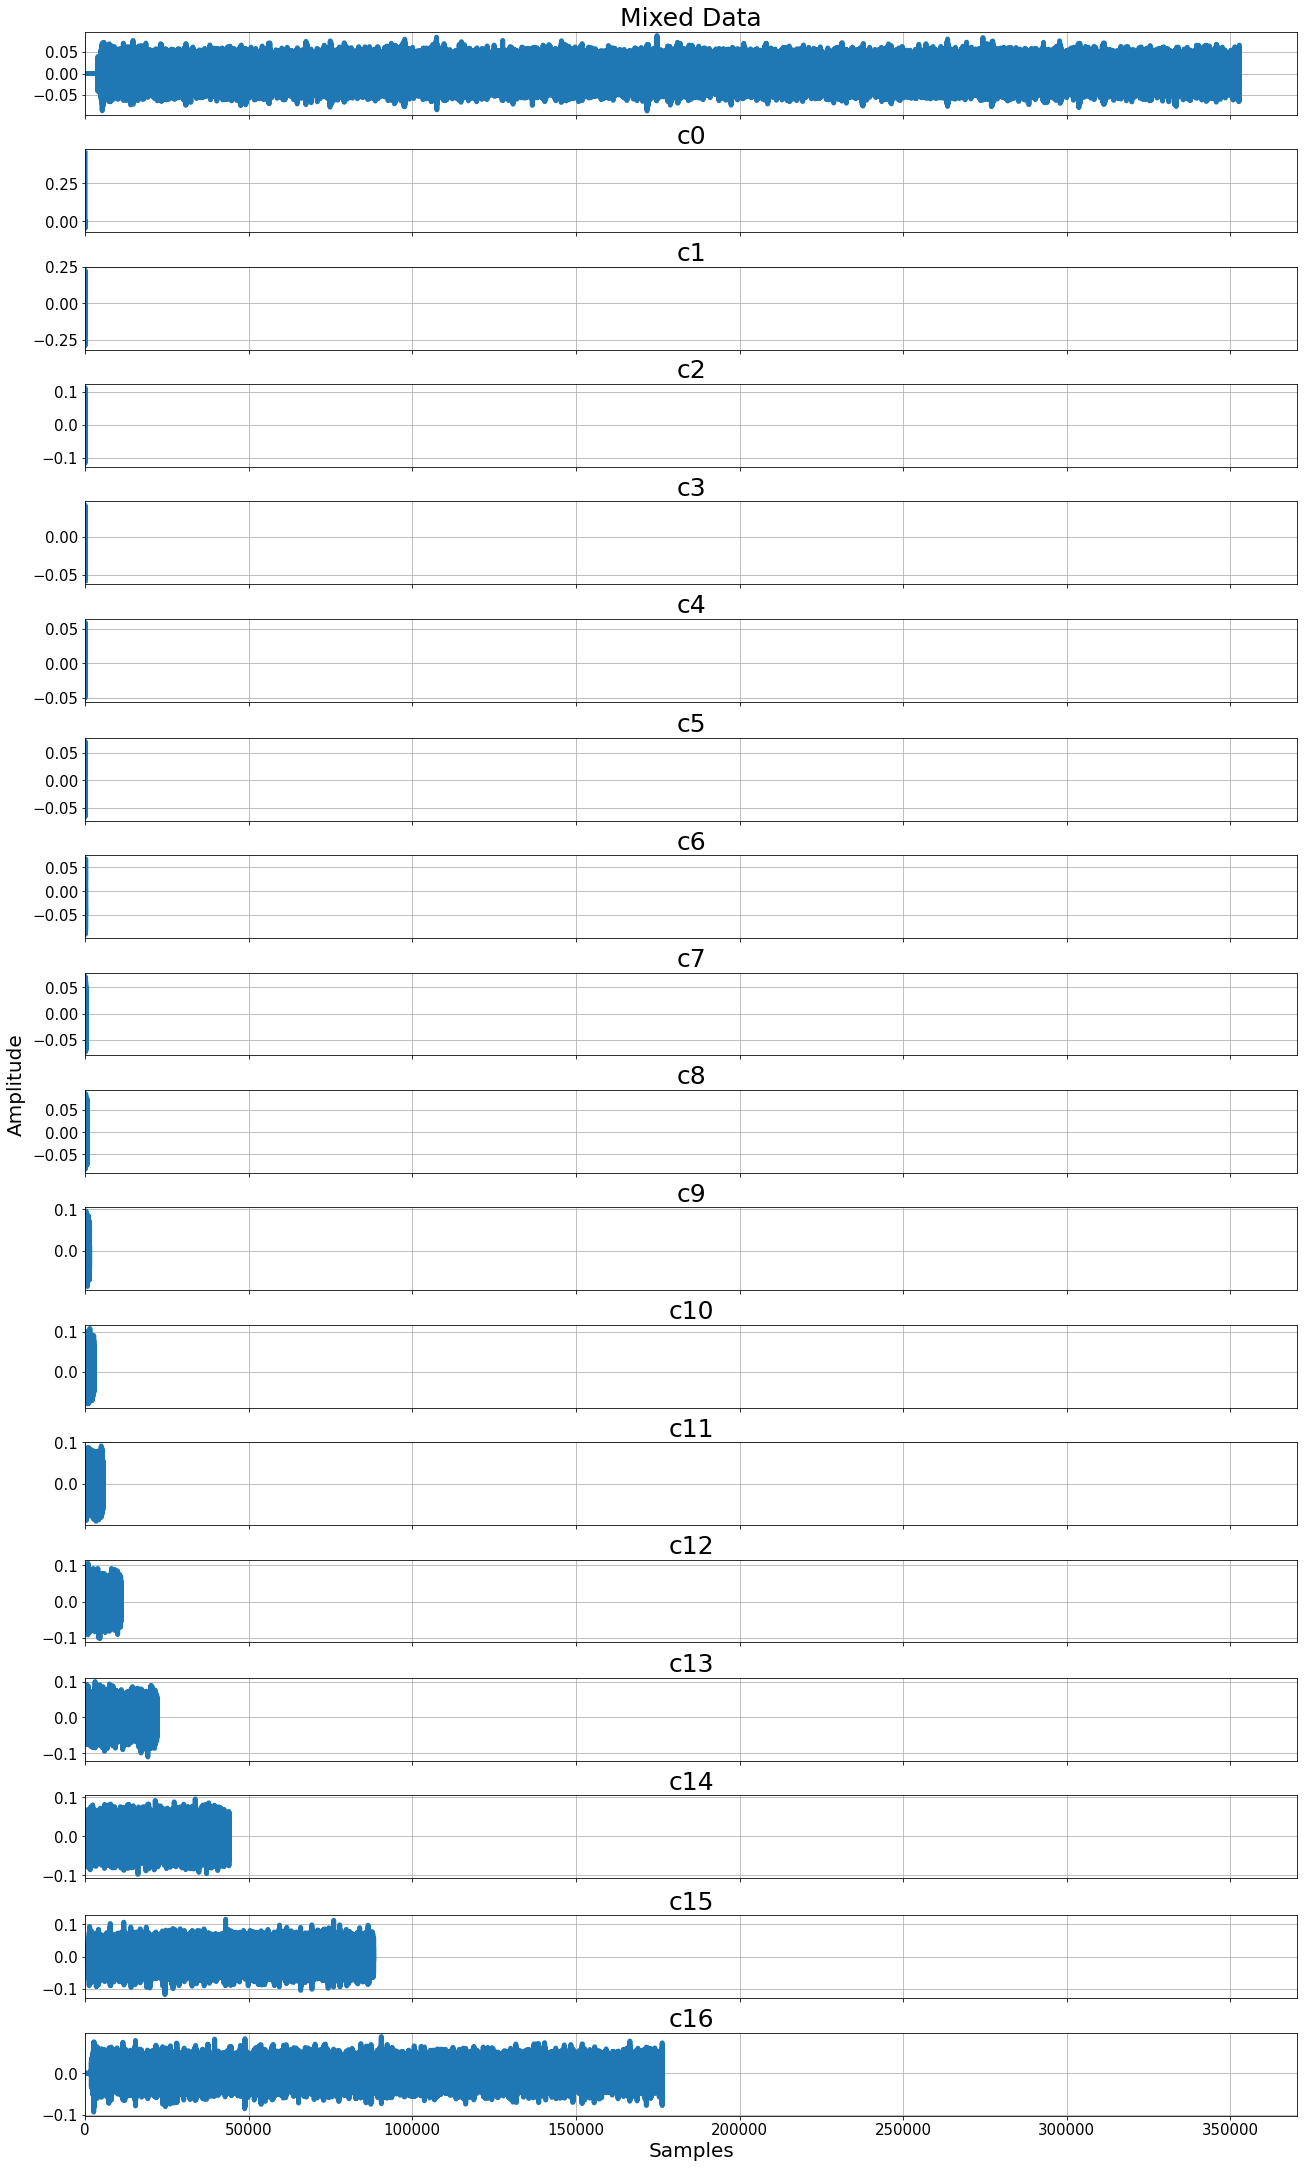

In [11]:
plot_wavelet(observations[3], wavelet, mode)

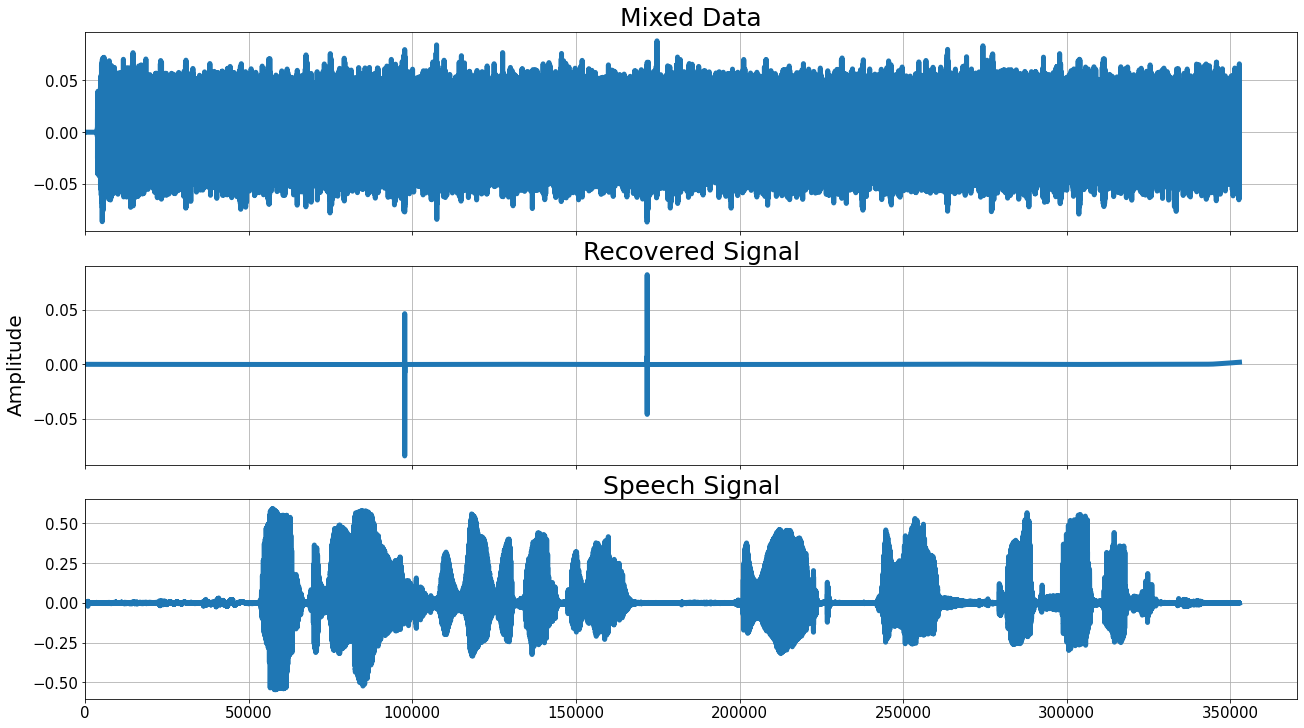

In [12]:
recov_spwn = wavelet_denoising(observations[3], wavelet, mode)

fig, axs = plt.subplots(3, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[0].plot(observations[3], lw=5)
axs[0].set_title('Mixed Data', fontsize=25)

axs[1].plot(recov_spwn, lw=5)
axs[1].set_title('Recovered Signal', fontsize=25)

axs[2].plot(audio_files[0], lw=5)
axs[2].set_title('Speech Signal', fontsize=25)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

# Street Noise + Music $d_{sn+m}$

In [13]:
coeff_dsnm = calc_wavelet(d_sn_m, wavelet, mode)

NameError: name 'calc_wavelet' is not defined

In [ ]:
plot_wavelet(coeff_dsnm, d_sn_m)

In [ ]:
recov_dsnm = recover_wavelet(coeff_dsnm, 0, 5)

fig, axs = plt.subplots(4, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[0].plot(d_sn_m, lw=5)
axs[0].set_title('Mixed Data', fontsize=25)

axs[1].plot(recov_dsnm, lw=5)
axs[1].set_title('Recovered Signal', fontsize=25)

axs[2].plot(audio_files[1], lw=5)
axs[2].set_title('Street Noise', fontsize=25)

axs[3].plot(audio_files[2], lw=5)
axs[3].set_title('Music Signal', fontsize=25)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

# Music + White Noise $d_{m+wn}$

In [ ]:
coeff_dmwn = calc_wavelet(d_m_wn, wavelet, mode)

In [ ]:
plot_wavelet(coeff_dmwn, d_m_wn)

In [ ]:
recov_dmwn = recover_wavelet(coeff_dmwn, 0, 4)

fig, axs = plt.subplots(4, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[0].plot(d_m_wn, lw=5)
axs[0].set_title('Mixed Data', fontsize=25)

axs[1].plot(recov_dmwn, lw=5)
axs[1].set_title('Recovered Signal', fontsize=25)

axs[2].plot(audio_files[3], lw=5)
axs[2].set_title('White Noise', fontsize=25)

axs[3].plot(audio_files[2], lw=5)
axs[3].set_title('Music Signal', fontsize=25)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()

# Street Noise + Music + Speec $d_{sn+m+s}$

In [ ]:
coeff_snms = calc_wavelet(d_sn_m_s, wavelet, mode)

In [ ]:
plot_wavelet(coeff_snms, d_sn_m_s)

In [ ]:
recov_snms = recover_wavelet(coeff_snms, 0, 5)

fig, axs = plt.subplots(5, 1, figsize=[18, 10], sharex=True, constrained_layout = True)
fig.supylabel('Amplitude', fontsize=20)

axs[0].plot(d_sn_m_s, lw=5)
axs[0].set_title('Mixed Data', fontsize=25)

axs[1].plot(recov_snms, lw=5)
axs[1].set_title('Recovered Signal', fontsize=25)

axs[2].plot(audio_files[1], lw=5)
axs[2].set_title('Street Noise', fontsize=25)

axs[3].plot(audio_files[2], lw=5)
axs[3].set_title('Music Signal', fontsize=25)

axs[4].plot(audio_files[0], lw=5)
axs[4].set_title('Speech Signal', fontsize=25)

for ax in axs:
    ax.set_xlim(0)
    ax.tick_params(labelsize=15)
    ax.grid()